<a href="https://colab.research.google.com/github/jpantojaj/Credit_Scoring_Specialization/blob/main/Sesion_3_NaiveModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importamos Librerias y Datos

In [1]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cr_loan = pd.read_excel('cr_loan2.xlsx',sheet_name='cr_loan2')
cr_loan

## Exploramos la data

In [3]:
cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
cr_loan.shape

(32581, 12)

In [5]:
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


##Empezemos a explorar los datos

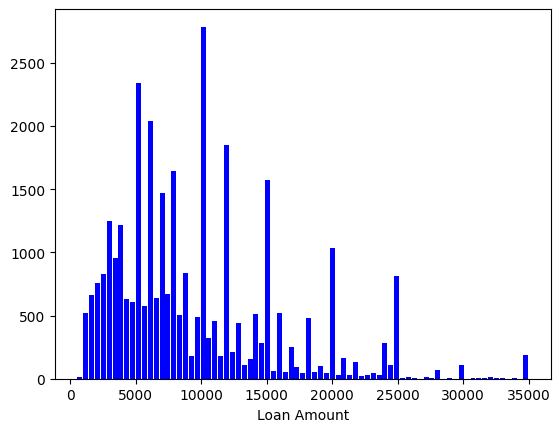

In [6]:
# Histograma de Montos
plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue', rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

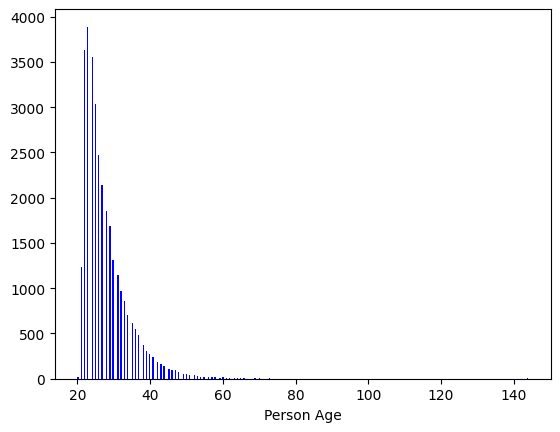

In [7]:
# Histograma de Edad
plt.hist(x=cr_loan['person_age'], bins='auto', color='blue', rwidth=0.85)
plt.xlabel("Person Age")
plt.show()

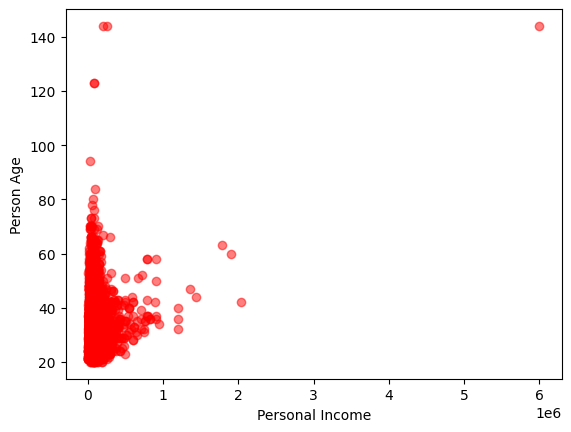

In [8]:
# Plotear la Edad contra el Ingreso
plt.scatter(cr_loan['person_income'], cr_loan['person_age'], c='red', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Person Age')
plt.show()

##Revisemos como cada variable explica el default

##Categórica

In [9]:
# Tabla cruzada de Destino y Y (loan status)
x=pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'])#, margins = True
x

loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,3722,1490
EDUCATION,5342,1111
HOMEIMPROVEMENT,2664,941
MEDICAL,4450,1621
PERSONAL,4423,1098
VENTURE,4872,847


In [10]:
y=pd.DataFrame(cr_loan['loan_status'].groupby(cr_loan['loan_intent']).mean())
y.rename(columns={'loan_status':'bad_rate'},inplace=True)
y

,bad_rate
loan_intent,
DEBTCONSOLIDATION,0.285879
EDUCATION,0.172168
HOMEIMPROVEMENT,0.261026
MEDICAL,0.267007
PERSONAL,0.198877
VENTURE,0.148103


In [11]:
pd.merge(x, y, how='inner', on='loan_intent')

,0,1,bad_rate
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,0.285879
EDUCATION,5342,1111,0.172168
HOMEIMPROVEMENT,2664,941,0.261026
MEDICAL,4450,1621,0.267007
PERSONAL,4423,1098,0.198877
VENTURE,4872,847,0.148103


##Cómo se verían los bad rates para las variables person_home_ownership y loan_grade?

In [13]:
y=pd.DataFrame(cr_loan['loan_status'].groupby(cr_loan['person_home_ownership']).mean())
y.rename(columns={'loan_status':'bad_rate'},inplace=True)
y

,bad_rate
person_home_ownership,
MORTGAGE,0.125707
OTHER,0.308411
OWN,0.074690
RENT,0.315700


In [14]:
y=pd.DataFrame(cr_loan['loan_status'].groupby(cr_loan['loan_grade']).mean())
y.rename(columns={'loan_status':'bad_rate'},inplace=True)
y

,bad_rate
loan_grade,
A,0.099564
B,0.162760
C,0.207340
D,0.590458
E,0.644191
F,0.705394
G,0.984375


##Numérica

In [15]:
cr_loan.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [16]:
pd.DataFrame(cr_loan['loan_status'].groupby(pd.cut(cr_loan['loan_percent_income'], bins=[0,0.25,0.50,0.75,1])).mean())

,loan_status
loan_percent_income,
"(0.0, 0.25]",0.143922
"(0.25, 0.5]",0.518733
"(0.5, 0.75]",0.786008
"(0.75, 1.0]",0.800000


##Cómo se verían los bad rates para person_age, person_emp_length y person_credit_hist_length

In [17]:
W=pd.DataFrame(cr_loan['loan_status'].groupby(pd.cut(cr_loan['person_age'], bins=[0,25,50,75,100])).mean())
W.rename(columns={'loan_status':'bad_rate'})
W

,loan_status
person_age,
"(0, 25]",0.230263
"(25, 50]",0.206599
"(50, 75]",0.262590
"(75, 100]",0.000000


In [18]:
from sklearn.preprocessing import KBinsDiscretizer
A=KBinsDiscretizer(n_bins=5, encode='ordinal', strategy = 'quantile').fit_transform(cr_loan[['person_age']])
B=pd.DataFrame(A).rename(columns = {0: 'person_age_disc'})
cr_loan[['person_age_disc']]=B
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_age_disc
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0.0
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,2.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,1.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,1.0


In [19]:
T=pd.DataFrame(cr_loan['loan_status'].groupby(cr_loan['person_age_disc']).mean())
T.rename(columns={'loan_status':'bad_rate'},inplace=True)
T

,bad_rate
person_age_disc,
0.0,0.257945
1.0,0.215380
2.0,0.216177
3.0,0.208431
4.0,0.205593


##Revisemos algunas interacciones

In [ ]:
# Tabla cruzada de tipo de vivienda, clasificación de riesgo y situación del préstamo
z=pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_grade'],
                  values=cr_loan['loan_status'], aggfunc='mean')
z

In [ ]:
# Gráfico de Cajas de porcentaje préstamo/ingreso por Situación del préstamo
cr_loan.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

In [ ]:
# Tabla cruzada de años de empleo (máximo) según situación del préstamo y tipo de vivienda
pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],values=cr_loan['person_emp_length'], aggfunc='mean')

## Depuramos la data

In [ ]:
# Crear arreglo de indices para marcar años de empleo mayores a 60
indices = cr_loan[cr_loan['person_emp_length'] > 60].index
indices.shape

In [ ]:
# Borrar datos atípicos
cr_loan_new = cr_loan.drop(indices)
cr_loan_new.shape

In [ ]:
#Min y max de antiguedad del empleo
print(cr_loan_new['person_emp_length'].min())
print(cr_loan_new['person_emp_length'].max())

In [ ]:
# Tabla cruzada de años de empleo (máximo) según situación del préstamo y tipo de vivienda
print(pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
            values=cr_loan_new['person_emp_length'], aggfunc=['min','max']))

In [ ]:
# Plotear la edad y el monto
plt.scatter(cr_loan_new['person_age'], cr_loan_new['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

In [ ]:
# Marca los registros con outliers en la variable edad
indices2=cr_loan_new[cr_loan_new['person_age'] > 100].index
indices2.shape

In [ ]:
# Borra datos atipicos en edad
cr_loan_new2 = cr_loan_new.drop(indices2)
cr_loan_new2.shape

In [ ]:
# Ploteo de Edad e Interes del Préstamo
import matplotlib
colors = ["blue","red"]
plt.scatter(cr_loan_new2['person_age'], cr_loan_new2['loan_int_rate'],
            c = cr_loan_new2['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

In [ ]:
# Array de valores nulos
cr_loan_new2.columns[cr_loan_new2.isnull().any()]

In [ ]:
# Primeros nulos de antiguedad de empleo
cr_loan_new2[cr_loan_new2['person_emp_length'].isnull()].head()

In [ ]:
# Imputar la mediana a los valores nulos
cr_loan_new2['person_emp_length'].fillna((cr_loan_new2['person_emp_length'].median()), inplace=True)

In [ ]:
# Histograma de antiguedad de empleo
n, bins, patches = plt.hist(cr_loan_new2['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [ ]:
# Cantidad de Nulos
print(cr_loan_new2['loan_int_rate'].isnull().value_counts())

In [ ]:
# Indice para identificar los nulos
indices3 = cr_loan_new2[cr_loan_new2['loan_int_rate'].isnull()].index
indices3.shape

In [ ]:
# Crea nueva tabla sin nulos
cr_loan_clean = cr_loan_new2.drop(indices3)
cr_loan_clean.shape

## Creamos un logit simple

In [ ]:
# Crea los datos de X e Y (regresion logit univariada)
X = cr_loan_clean[['loan_int_rate']]
y = cr_loan_clean[['loan_status']]

In [ ]:
# Crea el logit univariado
from sklearn.linear_model import LogisticRegression
clf_logistic_single = LogisticRegression(solver='lbfgs')
clf_logistic_single.fit(X, np.ravel(y))

In [ ]:
# Betas
print(clf_logistic_single.coef_)
# Intercepto
print(clf_logistic_single.intercept_)

## Creamos un logit multivariado (variables num y cat)

In [ ]:
cr_loan_clean['person_home_ownership'].unique()

In [ ]:
# Tratamiento de numéricas y categóricas
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

In [ ]:
# Tratamiento para variables categóricas
cred_str_onehot = pd.get_dummies(cred_str)

In [ ]:
# Unimos las subtablas y creamos nueva tabla
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)
cr_loan_prep.head()
cr_loan_prep.shape

In [ ]:
# Columnas de la tabla
print(cr_loan_prep.columns)

In [ ]:
# Crea x e y
X = cr_loan_prep.drop('loan_status',axis=1)
y = cr_loan_prep[['loan_status']]
print(X.shape)
print(y.shape)
print(X.columns)
print(y.columns)

In [ ]:
# Divide la muestra en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [ ]:
# Create and fit the logistic regression model
from sklearn.linear_model import LogisticRegression
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

In [ ]:
# Betas
print(clf_logistic.coef_)
# Intercepto
print(clf_logistic.intercept_)

In [ ]:
# Generamos las predicciones con la muestra test
preds = clf_logistic.predict_proba(X_test)

# Un pequeño vistazo sobre los primeros 5 valores predichos y reales
preds_df = pd.DataFrame(preds[:,1][0:10], columns = ['prob_default'])
true_df = y_test.head()

# Concatenar ambas vistas y comparar
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

In [ ]:
# Creamos nuestro dataframe de predicciones
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Basado en un corte predice el default o no de un préstamo
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Vemos cual es la cantidad de defaults basado en el corte
print(preds_df['loan_status'].value_counts())

In [ ]:
# Veamos un reporte que compara las predicciones con los defaults reales
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

In [ ]:
# Vista de la primera seccion de valores
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test,preds_df['loan_status']))

In [ ]:
# Vista del Recall
print(precision_recall_fscore_support(y_test,preds_df['loan_status'])[1])

In [ ]:
# Calcula la precisión del modelo
print(clf_logistic.score(X_test, y_test))

In [ ]:
# plotea la curva ROC
import sklearn.metrics as sm
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = sm.roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [ ]:
# Calcula AUC y muestra el valor
auc = sm.roc_auc_score(y_test, prob_default)
auc

In [ ]:
# Fija el corte en 0.5 y calcula el default
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
preds_df.head()

In [ ]:
# Muestra la matriz de confusión
print(sm.confusion_matrix(y_test,preds_df['loan_status']))

In [ ]:
# Fija el corte en 0.4 y calcula el default
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

In [ ]:
# Muestra la matriz de confusión
print(sm.confusion_matrix(y_test,preds_df['loan_status']))

In [ ]:
# Número de defaults
num_defaults = preds_df['loan_status'].value_counts()[1]

# Calcula los Recall
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

#Calcula el monto promedio de préstamo
avg_loan_amnt=X['loan_amnt'].mean()

# Calculo el impacto estimado del recall
print(avg_loan_amnt * num_defaults * (1 - default_recall))

## Generamos un modelo alternativo: XGBoost
Importante: El modelo solo trabaja con variables numéricas

In [ ]:
# Entrenamos el modelo con el algoritmo XGBoost
import xgboost as xgb
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Generamos preddiciones
gbt_preds = clf_gbt.predict_proba(X_test)
gbt_preds

In [ ]:
# Echamos una mirada a los primeros valores reales y de la prob default predicha
gbt_preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Genera la vista
print(pd.concat([true_df.reset_index(drop = True), gbt_preds_df], axis = 1))

In [ ]:
# Predict the labels for loan status
gbt_preds2 = clf_gbt.predict(X_test)
print(gbt_preds2)
print(gbt_preds2.sum())

In [ ]:
# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds2, target_names=target_names))

In [ ]:
# Creamos nuestro dataframe de predicciones
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])

# Basado en un corte predice el default o no de un préstamo
gbt_preds_df['loan_status'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Vemos cual es la cantidad de defaults basado en el corte
print(gbt_preds_df['loan_status'].value_counts())
gbt_preds_df.head()

In [ ]:
# Veamos un reporte que compara las predicciones con los defaults reales
from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds_df['loan_status'], target_names=target_names))

In [ ]:
# Importancia de cada variable
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

In [ ]:
# Ploteo de la importancia de cada variable
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

In [ ]:
# Setea el número de parcelas e iteraciones
params={'objective':'binary:logistic','seed':123,'eval_metric':'auc'}

# Construye la matriz DTrain para el XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Crea un dataframe para ver los resultados del CV
cv_df = xgb.cv(params,DTrain, num_boost_round = 500, nfold=10, shuffle = True)

# Imprime los resultados del CV
print(cv_df)

In [ ]:
# Calcula la media del AUC scores en la muestra test
print(np.mean(cv_df['test-auc-mean']))

In [ ]:
# Calcula el valor del CV para el modelo creado en el paso anterior
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf_gbt, X_train, np.ravel(y_train), cv = 10)
cv_scores

In [ ]:
# Plotea las auc promedio por cada iteracion
plt.plot(cv_df['test-auc-mean'],label='test')
plt.plot(cv_df['train-auc-mean'],label='train')
plt.title('AUC Score Over 500 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [ ]:
# Probar variando los hiperparametros
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calcula el valor del CV para el modelo creado en el paso anterior
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 10)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

## Probamos una tecnica de Balanceo de datos

In [ ]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()
print(count_nondefault,count_default)

In [ ]:
# Separamos la muestra en 2 partes: defaults y no defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]
print(nondefaults.shape)
print(defaults.shape)

In [ ]:
# Reducimos la muestra de nondefaults
nondefaults_under = nondefaults.sample(count_default)
print(nondefaults_under.shape)

In [ ]:
# Unimos la muestra de defaults y la de nondefaults reducida
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

In [ ]:
#Entrena el modelo con la data balanceada
X_train_under = X_y_train_under.drop('loan_status',axis=1)
y_train_under = X_y_train_under[['loan_status']]
clf_gbt_under = xgb.XGBClassifier().fit(X_train_under, np.ravel(y_train_under))
gbt_preds_under = clf_gbt_under.predict_proba(X_test)
gbt_preds_under2 = clf_gbt_under.predict(X_test)

In [ ]:
# Compara los rendimientos de ambos modelos
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds2, target_names=target_names))
print(classification_report(y_test, gbt_preds_under2, target_names=target_names))

In [ ]:
# Compara las dos matrices de confusion
print(sm.confusion_matrix(y_test,gbt_preds2))
print(sm.confusion_matrix(y_test,gbt_preds_under2))

In [ ]:
# Print and compare the AUC scores of the old and new models
print(sm.roc_auc_score(y_test, gbt_preds2))
print(sm.roc_auc_score(y_test, gbt_preds_under2))

## Compara Logit vs XGBoost

In [ ]:
# Reporte de Logit
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

# Reporte de XGBoost
print(classification_report(y_test, gbt_preds_df['loan_status'], target_names=target_names))

In [ ]:
# F-1 score del Logit
print(precision_recall_fscore_support(y_test,preds_df['loan_status'], average = 'macro')[2])

# F-1 score del XGBoost
print(precision_recall_fscore_support(y_test,gbt_preds_df['loan_status'], average = 'macro')[2])

## Comparativo ROC

In [ ]:
# Componentes del ROC
log_default = preds[:, 1]
gbt_default = gbt_preds[:, 1]
fallout_lr, sensitivity_lr, thresholds_lr = sm.roc_curve(y_test, log_default)
fallout_gbt, sensitivity_gbt, thresholds_gbt = sm.roc_curve(y_test, gbt_default)

In [ ]:
# Graficar el ROC
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [ ]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % sm.roc_auc_score(y_test, log_default))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % sm.roc_auc_score(y_test, gbt_default))

## Calibración

In [ ]:
#Crea valores para generar el gráfico
import sklearn.calibration as smc
frac_of_pos_lr, mean_pred_val_lr = smc.calibration_curve(y_test, log_default, n_bins=10)
frac_of_pos_gbt, mean_pred_val_gbt = smc.calibration_curve(y_test, gbt_default, n_bins=10)

In [ ]:
# Genera un gráfico que compara la calibración de ambos modelos
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

## Exporta datos para visualizarlos en Excel

In [ ]:
# Genera Tabla final (Test)
print(y_test.shape)
print(preds_df.head())
print(gbt_preds_df.head())
df_test=pd.concat([y_test['loan_status'].reset_index(drop=True),
                   preds_df['prob_default'].rename('lr_pd'),
                   gbt_preds_df['prob_default'].rename('gbt_pd')],axis=1)
df_test

In [ ]:
# Genera Tabla final (Train), solo con el propósito de comparar estabilidad
print(y_train.shape)
print(X_train.shape)
train_preds= clf_logistic.predict_proba(X_train)
train_gbt_preds= clf_gbt.predict_proba(X_train)
train_preds_df= pd.DataFrame(train_preds[:,1], columns = ['lr_pd'])
train_gbt_preds_df= pd.DataFrame(train_gbt_preds[:,1], columns = ['gbt_pd'])

In [ ]:
print(train_preds_df.head())
print(train_gbt_preds_df.head())
df_train=pd.concat([y_train['loan_status'].reset_index(drop=True),
                   train_preds_df['lr_pd'],
                   train_gbt_preds_df['gbt_pd']],axis=1)
df_train

In [ ]:
#Exporta la tabla a Excel
df_train.to_excel(r'C:\Users\johnn\cr_loan_trainpreds.xlsx', sheet_name='train', index = False)
df_test.to_excel (r'C:\Users\johnn\cr_loan_testpreds.xlsx', sheet_name='test', index = False)